In [1]:
import pandas as pd
import os

PROJ_ROOT = os.path.join(os.pardir)

import gensim

from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel


import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import operator

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm

import numpy as np


data_path = os.path.join(PROJ_ROOT, 
                         'data')
from pprint import pprint
import re
import pickle
import matplotlib.pyplot as plt

## Load Necessary Files

In [2]:
files = ['all_tokens.pkl','tweets_gdict.pkl','corpus.pkl',
         'texts.pkl']

for fn in tqdm(files):
    var=re.findall(r'(.*)\.',fn)[0]
    globals()[var] = pickle.load( open( data_path+'\\'+fn, 'rb' ) )

  0%|          | 0/4 [00:00<?, ?it/s]

## LDA Topic Modeling

### functions to computer coherence and make the lda models

In [3]:
# create a function to compute coherence values - used for the naive models
def compute_coherence(dictionary, corpus, texts, limit, start=2, step=1):
    '''Function to create a naive LDA model for a range of topics, then compute coherence values'''
    # empty lists to hold the models & computed coherence values
    coherence_values=[]
    model_list=[]
    
    # create a LDA model for each topic amount set between start & limit values
    for num_topic in tqdm(range(start, limit, step)):
        model = LdaModel(corpus=corpus,
                         num_topics=num_topic,
                         id2word=dictionary,
                         random_state=5)
        
        model_list.append(model) # add the model to the list
        
        # create a coherence model from the model
        coherencemodel=CoherenceModel(model=model,
                                      texts=[texts],
                                      dictionary=dictionary,
                                      coherence='c_v')
        
        #add the coherenced values from the list
        coherence_values.append(coherencemodel.get_coherence()) 
        
    return model_list, coherence_values


def compute_coherence_values(corpus, dictionary, texts, k, a, b):
    '''Function to create a lda model with set parameters, then compute coherence values'''
    lda_model = gensim.models.LdaMulticore(corpus=tqdm(corpus),
                                           id2word=dictionary,
                                           num_topics=k,
                                           alpha=a,
                                          chunksize=200,
                                          passes=10,
                                          random_state=5,
                                          eta=b,
                                          per_word_topics=True)
    
    # create a coherence value from the model
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=[texts],
                                         dictionary=dictionary,
                                         coherence='c_v')
    
    return lda_model, coherence_model_lda.get_coherence()


## Create a naive lda model with 1 to *n* topics

In [4]:
# #create a naive  lda model and coherence values for different topic lengths
# model_list, coherence_values = compute_coherence(dictionary=tweets_gdict,
#                                                  corpus=corpus,
#                                                  texts=texts,
#                                                  start=1,
#                                                  limit=15,
#                                                  step=1  )

In [5]:
# # save the naive models

# with open(data_path+'\\'+'naive_model_list_cv.pkl', 'wb') as f:
#     pickle.dump(model_list, f)
    
# with open(data_path+'\\'+'coherence_values.pkl', 'wb') as f:
#     pickle.dump(coherence_values, f)

#### Load the previously created models from the above two cells

In [6]:
model_list = pickle.load( open(data_path+'\\'+ 'naiave_model_list_cv.pkl', 'rb' ) )
coherence_values = pickle.load(open(data_path+'\\'+ 'coherence_values.pkl','rb'))

### Visualize coherence values to select number of topics to use for the LDA Model

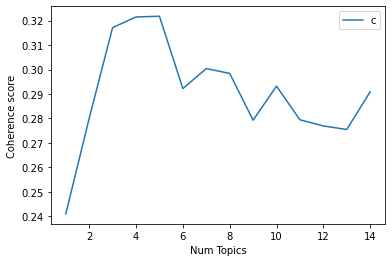

In [7]:
#plot the coherence values for different topic numbers
limit=15; start=1
x=range(start, limit)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend('coherence_values', loc='best')
plt.show()

In [8]:
#print the coherence values, and the index & cv for the highest cv value
pprint(coherence_values)
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
num_topics = len(coherence_values[:index+1])
print(index, value)
print(num_topics,' topics will be used for the LDA model')

[0.2409125597912077,
 0.2800806042947272,
 0.3171639175987016,
 0.3215055649681553,
 0.32179694064705433,
 0.2921852213487059,
 0.30038541763491633,
 0.2984128495380771,
 0.27927221557560233,
 0.2932006816855416,
 0.2794232567110878,
 0.2769115091589724,
 0.27545853819011845,
 0.29085384301829936]
4 0.32179694064705433
5  topics will be used for the LDA model


## Create a tuned LDA Model with 4 topics

In [9]:
# #decide on a topic number from above and train hyperparamters to train the model on

# topic_range = [4] # value determined by the above elbow plot above

# # range of alpha numbers to plug into the model   
# alpha = list(np.arange(0.01, 1, 0.3)) + [50/x  for x in topic_range]
# alpha.append('symmetric')
# alpha.append('asymmetric')

# # range of beta parameters to plug into the model
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# # create a minimized corpus set for validation if needed
# num_of_docs = len(corpus)
# corpus_sets = [corpus]
    
# corpus_title = ['100% Corpus']

# # empty dictionary to store parameter results with coherence values
# model_results = {'validation_set': [],
#                     'topics':[],
#                     'alpha':[],
#                  'beta':[],
#                   'coherence':[]}

# models=[] #empty list to store completed models
    
# if 1 ==1:
#     pbar = tqdm(total=len(topic_range) * len(alpha) * len(beta) * len(corpus_sets))
    
    
#     # create a model and store the corresponding values and results for each combination of parameters
#     for i in range(len(corpus_sets)):
#         for k in topic_range:
#             for a in alpha:
#                 for b in beta:
                    
#                     model, cv = compute_coherence_values(corpus=corpus_sets[i],
#                                                   dictionary=tweets_gdict,
#                                                      texts=texts,
#                                                   k=k,
#                                                   a=a,
#                                                         b=b)
                    
#                     model_results['validation_set'].append(corpus_title[i])
#                     model_results['topics'].append(k)
#                     model_results['alpha'].append(a)
#                     model_results['beta'].append(b)
#                     model_results['coherence'].append(cv)
#                     models.append(model)
                    
#                     pbar.update(1)

#     pbar.close()

#### Load the models from the above cell

In [10]:
models = pickle.load( open( data_path+'\\'+ 'all_lda_models_4t.pkl', 'rb' ) )
model_results = pickle.load(open(data_path+'\\'+ 'model_results_4t.pkl','rb'))

## Find and save the best model

In [11]:
#create a df of the param values and results
lda_tuning = pd.DataFrame(model_results)
lda_tuning.head()

,validation_set,topics,alpha,beta,coherence
0,100% Corpus,4,0.01,0.01,0.301495
1,100% Corpus,4,0.01,0.31,0.311898
2,100% Corpus,4,0.01,0.61,0.320993
3,100% Corpus,4,0.01,0.91,0.325178
4,100% Corpus,4,0.01,symmetric,0.317481


In [12]:
# find the row with the coherence value and display the parameters
idx =lda_tuning['coherence'].idxmax(axis=0)
lda_tuning.iloc[idx]

validation_set    100% Corpus
topics                      4
alpha               symmetric
beta                     0.91
coherence            0.348915
Name: 28, dtype: object

In [13]:
#create a df with the optimally tuned params
tuned_params = pd.DataFrame(lda_tuning.iloc[idx])
tuned_params.columns=['vals']
tuned_params.index.name='hp_params'
tuned_params.to_csv(data_path+'\\'+'tuned_lda_params_4t.csv', index=False)

In [14]:
# # save the tuned model
# with open(data_path+'\\'+'lda_best_tuned_model_3t.pkl', 'wb') as f:
#                 pickle.dump(models[idx], f)

# #save all of the models       
# with open(data_path+'\\'+'all_lda_models_3t.pkl', 'wb') as f:
#                 pickle.dump(models, f)

# # save all of the tuned model parameters
# with open(data_path+'\\'+'model_results_3t.pkl', 'wb') as f:
#                 pickle.dump(model_results, f)

## Display the top words from each topic

In [15]:
#display the topics along with the top 15 words for each topic
pprint(models[idx].print_topics(num_words=15))

[(0,
  '0.006*"immunity" + 0.003*"️" + 0.002*"doctor_policy_vaccine" + '
  '0.002*"insurance_pharmaceutical_biotech" + 0.002*"medtech_retweet" + '
  '0.002*"patient_nhs_fmrevolution_today" + '
  '0.002*"todaysmedicalupdate_medicine_health" + 0.002*"sale" + 0.002*"/j" + '
  '0.001*"$" + 0.001*"people_outside_city" + 0.001*"shot_javits_center_75" + '
  '0.001*"percent_queen_site_mayor" + 0.001*"bill_de_blasio" + '
  '0.001*"account_42_percent"'),
 (1,
  '0.016*"coronavirus" + 0.011*"death" + 0.005*"case" + 0.005*"daily" + '
  '0.003*"new_case" + 0.003*"coronaviruscoronavirus" + 0.003*"trend" + '
  '0.003*"today" + 0.002*"new" + 0.002*"░_░_░_░" + 0.002*"total" + '
  '0.002*"update" + 0.002*"feb" + 0.002*"maskup" + 0.002*"total_death"'),
 (2,
  '0.035*"coronavirus" + 0.018*"vaccine" + 0.017*"vaccinate" + 0.011*"people" '
  '+ 0.011*"pandemic" + 0.010*"virus" + 0.009*"get" + 0.006*"vaccination" + '
  '0.006*"need" + 0.006*"vax" + 0.005*"know" + 0.004*"want" + 0.004*"like" + '
  '0.004*"time

## Visualize the LDA model

In [16]:
#display the pLDAvis plot to visualize the LDA model
vis = pyLDAvis.gensim.prepare(models[idx], corpus, tweets_gdict)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.168998  0.122730       1        1  53.160989
3      0.152595 -0.127372       2        1  36.269410
1     -0.149185 -0.021719       3        1   5.615408
0     -0.172407  0.026362       4        1   4.954193, topic_info=             Term          Freq         Total Category  logprob  loglift
23        vaccine  22391.000000  22391.000000  Default  30.0000  30.0000
6     coronavirus  30729.000000  30729.000000  Default  29.0000  29.0000
37           dose   4025.000000   4025.000000  Default  28.0000  28.0000
992         death   1310.000000   1310.000000  Default  27.0000  27.0000
1122       pfizer   2435.000000   2435.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1576           j.     36.295864     81.425776   Topic4  -6.8120   2.1969
24              $     49.022756    505.178784   Topic4  -6.5114   0.6723
173        health     38.900895    921.196932   Topic4  -6.7427  -0.1597
174       healthy     28.207557    264.607852   Topic4  -7.0641   0.7663
1666            j     23.916538    197.129979   Topic4  -7.2291   0.8956

[225 rows x 6 columns], token_table=      Topic      Freq Term
term                      
24        1  0.546341    $
24        2  0.354330    $
24        4  0.096995    $
8421      1  0.018944   /j
8421      2  0.018944   /j
...     ...       ...  ...
1764      3  0.001905    💉
1764      4  0.015238    💉
6203      1  0.043462    😎
6203      2  0.043462    😎
6203      4  0.912706    😎

[582 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

In [17]:
pyLDAvis.save_html(vis,data_path+'\\'+'covid_topics_4t.html')